### Answer 3.

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

'''
After careful testing and implementation, I determined that the optimal approach is to define both a convergence rate
and a maximum number of epochs. This ensures that we avoid situations where the classifier fails to converge, which could
lead to infinite loops. To identify the appropriate parameters, I conducted experiments using mini training and testing
datasets to observe how many epochs were typically required for each degree to converge. Based on these observations, I set
the maximum number of epochs to 50, which provides a reasonable balance between efficiency and reliability.
This combination allows the algorithm to terminate either when convergence is achieved or when the maximum number of
epochs is reached, ensuring both robustness and computational efficiency
'''


# polynomial kernel Kd(p, q) = (p · q)^d
def polynomial_kernel(X1, X2, d):
    return jnp.power(jnp.dot(X1, X2.T), d)

def train_test_split(X, y, degree):
    # shuffle the data for and take 80% for training and 20% for testing
    # split the data into training and test sets

    ratio =0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)

    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    # convert them into jax format for faster implementaion
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    # Bc it's time consuming to compute the kernals for each epoch, I've decided to precompute them and use them directly for each run
    kernel_train = polynomial_kernel(X_train, X_train, degree)
    kernel_test = polynomial_kernel(X_train, X_test, degree)

    return X_train, X_test, y_train, y_test, kernel_train, kernel_test

# this function will train the data using One-vs-Rest method
# a step by step explanation for OvR can be found on answer 2
def kernel_perceptron_train(y_train, kernel_train, classes):
    max_epochs = 50 # max number of epochs
    n_samples = kernel_train.shape[0]
    n_classes = len(classes)
    # the wegiht is set to zero for each class
    alpha = jnp.zeros((n_classes, n_samples), dtype=jnp.float32)
    convergance_rate = 0.01

    # this helper function aims to update the weight
    def update_weights(state):
        alpha, epoch,prev_updates = state
        # for each sample, create binary labels for all classes
        y_binary = jnp.where(y_train[:, None] == classes, 1, -1)
        # compute the predictions for all samples and classes
        predictions = jnp.sign(jnp.dot(alpha, kernel_train.T))
        # identify where the predictions are incorrect and calculate the updates accordingly
        # transposes y_binary to match the shape of predictions
        updates = jnp.where(predictions != y_binary.T, y_binary.T, 0)
        alpha = alpha + updates
        avg_updates = jnp.mean(jnp.abs(updates)) # calculate the avg number of updates
        return alpha, epoch + 1, avg_updates

     # a helper function that returns true if epoch is less than max_epochs
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergance_rate)

    # settings at the start : zero indicates to epoch=0, float('inf') as there's no previous update info
    alpha, _ ,_= jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, classes

# prediction of (OvR) method
@jax.jit
def kernel_perceptron_predict(alpha, classes, kernel_matrix):
    # calculate the weighted_sums for each class
    weighted_sums = jnp.dot(alpha, kernel_matrix)
    # take the test sample that has highest confidence score
    predicted_indices = jnp.argmax(weighted_sums, axis=0)
    return classes[predicted_indices]

# compute the error rate
def compute_error(y_true, y_pred):
    n=len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors /n ) * 100

def main():
  # read the data from zipcombo file and then convert the feature&labels
  # the use of float32 here is to accelerate the execution time
  data = []
  with open('zipcombo.dat.txt', 'r') as f:
      for line in f:
              values = list(map(float, line.strip().split()))
              data.append(values)
      data = np.array(data, dtype=np.float32)
  X = data[:, 1:].astype(jnp.float32)
  y = data[:, 0].astype(jnp.float32)


  poly_degrees = range(1, 8)
  train_errors = []
  test_errors = []

  for d in poly_degrees:
      compute_train_errors = []
      compute_run_test_errors = []
      for _ in range(20):
          # first, split the train and test data
          X_train, X_test, y_train, y_test, kernel_train, kernel_test = train_test_split(X, y, degree=d)

          # train the data
          classes = np.unique(y_train).astype(np.int32)
          alpha, classes = kernel_perceptron_train(y_train, kernel_train, classes)

          # calculate the rates of the errors (training data)
          y_train_pred = kernel_perceptron_predict(alpha, classes, kernel_train)
          train_error = compute_error(y_train, y_train_pred)

          # calculate the rates of the errors (testing data)
          y_test_pred = kernel_perceptron_predict(alpha, classes, kernel_test)
          test_error = compute_error(y_test, y_test_pred)

          compute_train_errors.append(train_error)
          compute_run_test_errors.append(test_error)

      train_errors.append(compute_train_errors)
      test_errors.append(compute_run_test_errors)

  #   for each degree, by averaging over the 20 runs, calculate mean and standard deviation for train and test errors
  avg_train_errors = [(np.mean(errors), np.std(errors)) for errors in train_errors]
  avg_test_errors = [(np.mean(errors), np.std(errors)) for errors in test_errors]


  print(f"{'Degree ':<10}{'Train Error':<30}{'Test Error':<30}")
  for d, (train, test) in zip(poly_degrees, zip(avg_train_errors, avg_test_errors)):
      train_mean, train_std = train
      test_mean, test_std = test
      print(f"{d:<10}{train_mean:.2f}% ± {train_std:.2f}%{'':<10}{test_mean:.2f}% ± {test_std:.2f}%")

if __name__ == "__main__":
    main()


Degree    Train Error                   Test Error                    
1         6.84% ± 0.14%          7.55% ± 0.57%
2         4.54% ± 0.10%          6.02% ± 0.41%
3         3.72% ± 0.09%          5.56% ± 0.64%
4         3.80% ± 0.11%          5.90% ± 0.63%
5         3.84% ± 0.08%          6.44% ± 0.50%
6         3.83% ± 0.09%          6.83% ± 0.60%
7         3.86% ± 0.10%          7.41% ± 0.61%


We observe that as the polynomial degree increases from 1 to 3, the train and test errors decrease significantly. This suggests that lower degrees are not capturing the complexity of the patterns in the dataset effectively. However, as the degree increases further (4 to 7), the errors begin to plateau, indicating that the model is reaching its capacity to generalize the data effectively. The lowest test error is observed at degree 3, and interestingly, beyond this degree, the test error slightly increases, which might indicate slight overfitting. As expected, the train errors are consistently lower than the test errors, confirming that the model fits the training data better than it does the unseen test data. Additionally, the standard deviation percentages for both train and test errors remain relatively low, indicating stability in the performance across multiple runs.

### Answer 4 and 5.


Cross-Validation Results:
Run 1: Best Degree = 3, Train Error = 3.79%, Test Error = 5.05%
Run 2: Best Degree = 2, Train Error = 4.48%, Test Error = 6.56%
Run 3: Best Degree = 4, Train Error = 3.78%, Test Error = 6.18%
Run 4: Best Degree = 4, Train Error = 3.80%, Test Error = 6.18%
Run 5: Best Degree = 3, Train Error = 3.90%, Test Error = 5.54%
Run 6: Best Degree = 4, Train Error = 3.83%, Test Error = 7.15%
Run 7: Best Degree = 4, Train Error = 4.05%, Test Error = 5.70%
Run 8: Best Degree = 3, Train Error = 3.54%, Test Error = 6.77%
Run 9: Best Degree = 5, Train Error = 3.89%, Test Error = 6.34%
Run 10: Best Degree = 4, Train Error = 3.75%, Test Error = 6.72%
Run 11: Best Degree = 2, Train Error = 4.46%, Test Error = 6.34%
Run 12: Best Degree = 3, Train Error = 3.87%, Test Error = 5.97%
Run 13: Best Degree = 4, Train Error = 3.82%, Test Error = 6.83%
Run 14: Best Degree = 2, Train Error = 4.50%, Test Error = 6.02%
Run 15: Best Degree = 4, Train Error = 3.83%, Test Error = 7.37%
Run 16:

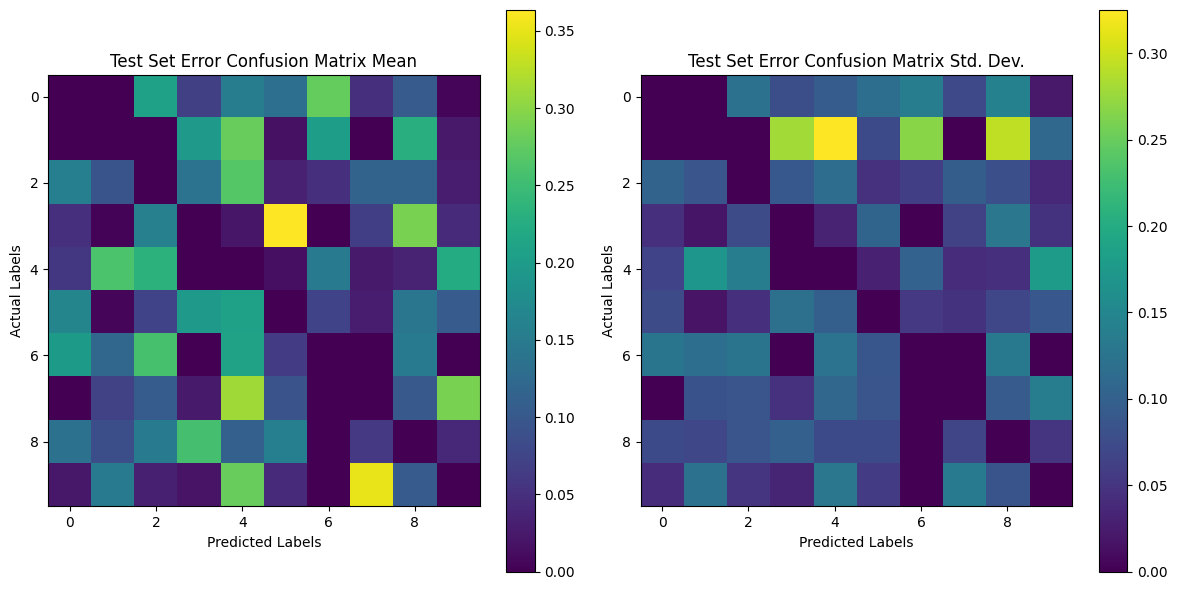

Predicted Labels     0           1           2           3           4           5           6           7           8           9      
----------------------------------------------------------------------------------------------------------------------------------------
Actual Label 0 0.00%±0.00% 0.00%±0.00% 0.21%±0.12% 0.07%±0.08% 0.15%±0.09% 0.13%±0.12% 0.28%±0.14% 0.05%±0.07% 0.10%±0.14% 0.01%±0.02% 
Actual Label 1 0.00%±0.00% 0.00%±0.00% 0.00%±0.00% 0.20%±0.28% 0.28%±0.33% 0.02%±0.07% 0.20%±0.27% 0.00%±0.00% 0.23%±0.29% 0.03%±0.11% 
Actual Label 2 0.16%±0.10% 0.09%±0.09% 0.00%±0.00% 0.14%±0.09% 0.27%±0.12% 0.03%±0.05% 0.05%±0.06% 0.12%±0.10% 0.12%±0.08% 0.03%±0.04% 
Actual Label 3 0.05%±0.05% 0.00%±0.02% 0.16%±0.07% 0.00%±0.00% 0.02%±0.03% 0.36%±0.11% 0.00%±0.00% 0.07%±0.06% 0.29%±0.13% 0.04%±0.05% 
Actual Label 4 0.06%±0.07% 0.26%±0.17% 0.23%±0.14% 0.00%±0.00% 0.00%±0.00% 0.01%±0.03% 0.15%±0.10% 0.03%±0.04% 0.03%±0.04% 0.22%±0.18% 
Actual Label 5 0.17%±0.08% 0.01%±0.02% 0.07%±0

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# polynomial kernel Kd(p, q) = (p · q)^d
@jax.jit
def polynomial_kernel(X1, X2, d):
    return jnp.power(jnp.dot(X1, X2.T), d)

def train_test_split(X, y):
    # shuffle the data for and take 80% for training and 20% for testing
    # split the data into training and test sets

    ratio =0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)

    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    # convert them into jax format for faster implementaion
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    return X_train, X_test, y_train, y_test

# this function will train the data using One-vs-Rest method
# a step by step explanation for OvR can be found on answer 2
def kernel_perceptron_train(y_train, kernel_train, classes):
    max_epochs = 50 # max number of epochs
    n_samples = kernel_train.shape[0]
    n_classes = len(classes)
    # the wegiht is set to zero for each class
    alpha = jnp.zeros((n_classes, n_samples), dtype=jnp.float32)
    convergance_rate = 0.01

    # this helper function aims to update the weight
    def update_weights(state):
        alpha, epoch,prev_updates = state
        # for each sample, create binary labels for all classes
        y_binary = jnp.where(y_train[:, None] == classes, 1, -1)
        # compute the predictions for all samples and classes
        predictions = jnp.sign(jnp.dot(alpha, kernel_train.T))
        # identify where the predictions are incorrect and calculate the updates accordingly
        # transposes y_binary to match the shape of predictions
        updates = jnp.where(predictions != y_binary.T, y_binary.T, 0)
        alpha = alpha + updates
        avg_updates = jnp.mean(jnp.abs(updates)) # calculate the avg number of updates
        return alpha, epoch + 1, avg_updates

     # a helper function that returns true if epoch is less than max_epochs
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergance_rate)

    # settings at the start : zero indicates to epoch=0, float('inf') as there's no previous update info
    alpha, _ ,_= jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, classes

# prediction of (OvR) method
@jax.jit
def kernel_perceptron_predict(alpha, classes, kernel_matrix):
    # calculate the weighted_sums for each class
    weighted_sums = jnp.dot(alpha, kernel_matrix)
    # take the test sample that has highest confidence score
    predicted_indices = jnp.argmax(weighted_sums, axis=0)
    return classes[predicted_indices]

# compute error
def compute_error(y_true, y_pred):
    n = len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors / n) * 100

# compute confusion rate
def compute_confusion_matrix(y_true, y_pred, y):
    classes = np.unique(y)  # get the classes
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes) # build the confusion matrix
    #We set the diagonal matrix to zero to exclude the true predictions, therefore we'll only only count the false predictions
    np.fill_diagonal(conf_matrix, 0)
    rows= conf_matrix.sum(axis=1, keepdims=True)
    rows[rows == 0] = 1 # to avoid the devision by zero
    #  “Number of times digit a was mistaken for digit b (test set)”/“Number of digit a points (test set)
    rate = conf_matrix / rows
    return rate

# precompute kernals to speed up the computaion of cross validation
def precompute_kernels(X, degrees):
    return {d: polynomial_kernel(X, X, d) for d in degrees}

# cross validation function
def cross_validate(X, y, degrees, precomputed_kernels):
    folds=5
    n_samples = len(X) # to get the number of samples in the dataset
    fold_size = n_samples // folds # to obtain the size of each fold
    arr_indices = np.arange(n_samples) # an array of ordered samples
    np.random.shuffle(arr_indices)

    best_degree_errors = [] # list to store the the validation errors for each degree

    for d in degrees:
        fold_errors = [] # to store the errors for each fold
        kernel = precomputed_kernels[d] # to obtain the precomputed kernals for the current degree

        for fold in range(folds):
            val_indices = arr_indices[fold * fold_size : (fold + 1) * fold_size] # select the indices for the validation set for the current fold
            train_indices = np.setdiff1d(arr_indices, val_indices) # extract all the indices not in val_indices

            # extract the training and validation kernals by slicing the precomputed kernal
            kernel_train = kernel[train_indices][:, train_indices]
            kernel_val = kernel[train_indices][:, val_indices]

            y_train, y_val = y[train_indices], y[val_indices] # split the train and validation y
            classes = np.unique(y_train).astype(np.int32)
            alpha, _ = kernel_perceptron_train(y_train, kernel_train, classes) # train
            y_val_pred = kernel_perceptron_predict(alpha, classes, kernel_val) # predict

            val_error = compute_error(y_val, y_val_pred) # compute the error
            fold_errors.append(val_error) # store the errors

        mean_error = np.mean(fold_errors) # for the current polynomial degree, compute the mean of all folds
        best_degree_errors.append((d, mean_error))

    best_d = min(best_degree_errors, key=lambda x: x[1])[0] # retrieve the degree that has the lowest error
    return best_d

def main():
  # read the data from zipcombo file and then convert the feature&labels
  # the use of float32 here is to accelerate the execution time
  data = []
  with open('zipcombo.dat.txt', 'r') as f:
      for line in f:
              values = list(map(float, line.strip().split()))
              data.append(values)
      data = np.array(data, dtype=np.float32)
  X = data[:, 1:].astype(jnp.float32)
  y = data[:, 0].astype(jnp.float32)

  poly_degrees = range(1, 8)
  train_errors = []
  test_errors = []
  arr_best_degrees = []
  confusion_matrices = []

  # To speed up the excution time, we precompute full kernels for each degree
  precomputed_kernels = precompute_kernels(X, poly_degrees)

  for _ in range(20):

      X_train, X_test, y_train, y_test = train_test_split(X, y)
      # perform cross validation with precomputed kernels to obtain the best degree
      best_degree = cross_validate(X_train, y_train, poly_degrees, precomputed_kernels)
      arr_best_degrees.append(best_degree)

      # now we retrain with the best degree
      kernel_train = polynomial_kernel(X_train, X_train, best_degree)
      kernel_test = polynomial_kernel(X_train, X_test, best_degree)
      classes = np.unique(y_train).astype(np.int32)
      alpha, classes = kernel_perceptron_train(y_train, kernel_train, classes)
      # predict
      y_train_pred = kernel_perceptron_predict(alpha, classes, kernel_train)
      y_test_pred = kernel_perceptron_predict(alpha, classes, kernel_test)

      # compute the errors of train and test
      train_error = compute_error(y_train, y_train_pred)
      test_error = compute_error(y_test, y_test_pred)

      train_errors.append(train_error)
      test_errors.append(test_error)
      # compute the rate of the confusion matrix
      conf_matrix = compute_confusion_matrix(y_test, y_test_pred, y)
      confusion_matrices.append(conf_matrix)

# prin and plot the results
  print("\nCross-Validation Results:")
  for run in range(20):
      print(f"Run {run + 1}: Best Degree = {arr_best_degrees[run]}, Train Error = {train_errors[run]:.2f}%, Test Error = {test_errors[run]:.2f}%")

  mean_best_degree = np.mean(arr_best_degrees)
  std_best_degree = np.std(arr_best_degrees)
  mean_train_error = np.mean(train_errors)
  std_train_error = np.std(train_errors)
  mean_test_error = np.mean(test_errors)
  std_test_error = np.std(test_errors)

  print("\n Across Runs :")
  print(f"Best Degree (mean ± std): {mean_best_degree:.2f} ± {std_best_degree:.2f}")
  print(f"Train Error (mean ± std %): {mean_train_error:.2f}% ± {std_train_error:.2f}%")
  print(f"Test Error (mean ± std %): {mean_test_error:.2f}% ± {std_test_error:.2f}%")


  mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
  std_confusion_matrix = np.std(confusion_matrices, axis=0)

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.imshow(mean_confusion_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title("Test Set Error Confusion Matrix Mean")
  plt.xlabel("Predicted Labels")
  plt.ylabel("Actual Labels")

  plt.subplot(1, 2, 2)
  plt.imshow(std_confusion_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title("Test Set Error Confusion Matrix Std. Dev.")
  plt.xlabel("Predicted Labels")
  plt.ylabel("Actual Labels")

  plt.tight_layout()
  plt.show()

  num_classes = mean_confusion_matrix.shape[0]

  header = "Predicted Labels".center(15) + "".join([f"{i}".center(12) for i in range(num_classes)])
  print(header)
  print("-" * len(header))

  for i in range(num_classes):
    row = f"Actual Label {i}".ljust(15)
    for j in range(num_classes):
            mean_val = mean_confusion_matrix[i, j]
            std_val = std_confusion_matrix[i, j]
            cell = f"{mean_val:.2f}%±{std_val:.2f}%"
            row += cell.center(12)
    print(row)



if __name__ == "__main__":
    main()

**Cross-Validation Results**:The 5-fold cross-validation method appears to work effectively in selecting the best polynomial degree for the kernel perceptron. According to the results, we see that the optimal polynomial degree varies accross the runs but on average, the best degree is around 3.25 ± 0.99. This indicates that the degrees around this average captures the patterns in the dataset effectively. Degree 3, in particular, achieves the lowest test error in several runs, showing a good balance between underfitting and overfitting, which helps the model generalize well to unseen data.The mean train error of 4.11% ± 0.72% and mean test error of 6.29% ± 0.56% indicate relatively consistent performance across the runs with low variability.

**Confusion matrix**: We notice that some digits have higher misclassification rates with specific other digits, and some digits have very low error rates overall, indicating that the model performs well in identifying them. For example, digit 0 has consistently low off-diagonal values, suggesting it is easily distinguishable from other digits. The standard deviation values in the matrix indicate that certain misclassifications are consistent across the 20 runs; for instance, actual 1 is always predicted as 4 with an error rate of 0.33%. Similarly, in the mean confusion matrix we notice that actual label 3 is misclassified with predicted label 5 with a rate of 0.36%. The misclassifications are generally concentrated near the diagonal, reflecting confusion between digits with similar shapes or features (3 and 5, 8 and 9). Which is a typical pattern in digit classification tasks, where similar-looking digits are harder to differentiate.

In [ ]:
import jax

# Clear JAX caches
jax.clear_caches()


### Answer 6

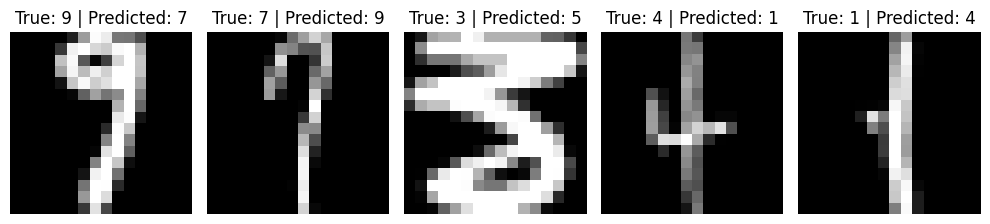

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# polynomial kernel Kd(p, q) = (p · q)^d
@jax.jit
def polynomial_kernel(X1, X2, d):
    return jnp.power(jnp.dot(X1, X2.T), d)

def train_test_split(X, y):
    # shuffle the data for and take 80% for training and 20% for testing
    # split the data into training and test sets

    ratio =0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)

    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    # convert them into jax format for faster implementaion
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    return X_train, X_test, y_train, y_test

# this function will train the data using One-vs-Rest method
# a step by step explanation for OvR can be found on answer 2
def kernel_perceptron_train(y_train, kernel_train, classes):
    max_epochs = 50 # max number of epochs
    n_samples = kernel_train.shape[0]
    n_classes = len(classes)
    # the wegiht is set to zero for each class
    alpha = jnp.zeros((n_classes, n_samples), dtype=jnp.float32)
    convergance_rate = 0.01

    # this helper function aims to update the weight
    def update_weights(state):
        alpha, epoch,prev_updates = state
        # for each sample, create binary labels for all classes
        y_binary = jnp.where(y_train[:, None] == classes, 1, -1)
        # compute the predictions for all samples and classes
        predictions = jnp.sign(jnp.dot(alpha, kernel_train.T))
        # identify where the predictions are incorrect and calculate the updates accordingly
        # transposes y_binary to match the shape of predictions
        updates = jnp.where(predictions != y_binary.T, y_binary.T, 0)
        alpha = alpha + updates
        avg_updates = jnp.mean(jnp.abs(updates)) # calculate the avg number of updates
        return alpha, epoch + 1, avg_updates

     # a helper function that returns true if epoch is less than max_epochs
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergance_rate)

    # settings at the start : zero indicates to epoch=0, float('inf') as there's no previous update info
    alpha, _ ,_= jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, classes

# prediction of (OvR) method
@jax.jit
def kernel_perceptron_predict(alpha, classes, kernel_matrix):
    # calculate the weighted_sums for each class
    weighted_sums = jnp.dot(alpha, kernel_matrix)
    # take the test sample that has highest confidence score
    predicted_indices = jnp.argmax(weighted_sums, axis=0)
    return classes[predicted_indices]

# compute error
def compute_error(y_true, y_pred):
    n = len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors / n) * 100

# compute confusion rate
def compute_confusion_matrix(y_true, y_pred, y):
    classes = np.unique(y)  # get the classes
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes) # build the confusion matrix
    #We set the diagonal matrix to zero to exclude the true predictions, therefore we'll only only count the false predictions
    np.fill_diagonal(conf_matrix, 0)
    rows= conf_matrix.sum(axis=1, keepdims=True)
    rows[rows == 0] = 1 # to avoid the devision by zero
    #  “Number of times digit a was mistaken for digit b (test set)”/“Number of digit a points (test set)
    rate = conf_matrix / rows
    return rate

# precompute kernals to speed up the computaion of cross validation
def precompute_kernels(X, degrees):
    return {d: polynomial_kernel(X, X, d) for d in degrees}

# cross validation function
def cross_validate(X, y, degrees, precomputed_kernels):
    folds=5
    n_samples = len(X) # to get the number of samples in the dataset
    fold_size = n_samples // folds # to obtain the size of each fold
    arr_indices = np.arange(n_samples) # an array of ordered samples
    np.random.shuffle(arr_indices)

    best_degree_errors = [] # list to store the the validation errors for each degree

    for d in degrees:
        fold_errors = [] # to store the errors for each fold
        kernel = precomputed_kernels[d] # to obtain the precomputed kernals for the current degree

        for fold in range(folds):
            val_indices = arr_indices[fold * fold_size : (fold + 1) * fold_size] # select the indices for the validation set for the current fold
            train_indices = np.setdiff1d(arr_indices, val_indices) # extract all the indices not in val_indices

            # extract the training and validation kernals by slicing the precomputed kernal
            kernel_train = kernel[train_indices][:, train_indices]
            kernel_val = kernel[train_indices][:, val_indices]

            y_train, y_val = y[train_indices], y[val_indices] # split the train and validation y
            classes = np.unique(y_train).astype(np.int32)
            alpha, _ = kernel_perceptron_train(y_train, kernel_train, classes) # train
            y_val_pred = kernel_perceptron_predict(alpha, classes, kernel_val) # predict

            val_error = compute_error(y_val, y_val_pred) # compute the error
            fold_errors.append(val_error) # store the errors

        mean_error = np.mean(fold_errors) # for the current polynomial degree, compute the mean of all folds
        best_degree_errors.append((d, mean_error))

    best_d = min(best_degree_errors, key=lambda x: x[1])[0] # retrieve the degree that has the lowest error
    return best_d


def main():
    # read the data from zipcombo file and then convert the feature&labels
    # the use of float32 here is to accelerate the execution time
    data = []
    with open('zipcombo.dat.txt', 'r') as f:
        for line in f:
                values = list(map(float, line.strip().split()))
                data.append(values)
        data = np.array(data, dtype=np.float32)
    X = data[:, 1:].astype(jnp.float32)
    y = data[:, 0].astype(jnp.float32)

    poly_degrees = range(1, 8)
    train_errors = []
    test_errors = []
    confusion_matrix_sum = np.zeros((10, 10))



    # To speed up the excution time, we precompute full kernels for each degree
    precomputed_kernels = precompute_kernels(X, poly_degrees)

    for _ in range(20):

        X_train, X_test, y_train, y_test = train_test_split(X, y)
        # perform cross validation with precomputed kernels to obtain the best degree
        best_degree = cross_validate(X_train, y_train, poly_degrees, precomputed_kernels)

        # now we retrain with the best degree
        kernel_train = polynomial_kernel(X_train, X_train, best_degree)
        kernel_test = polynomial_kernel(X_train, X_test, best_degree)
        classes = np.unique(y_train).astype(np.int32)
        alpha, classes = kernel_perceptron_train(y_train, kernel_train, classes)
        # predict
        y_train_pred = kernel_perceptron_predict(alpha, classes, kernel_train)
        y_test_pred = kernel_perceptron_predict(alpha, classes, kernel_test)

        # compute the rate of the confusion matrix
        conf_matrix = compute_confusion_matrix(y_test, y_test_pred, y)
        np.fill_diagonal(conf_matrix, 0)
        confusion_matrix_sum += conf_matrix

    # convert the confusion matrix into a 1D vector, sort the indices in descending order, convert the sorted indices back to
    # 2D indices for the matrix (true and predicted labels) combine the true and predicted label indices into pairs,
    # and slice the first 5 pairs.
    top_misclassified_pairs = np.dstack(np.unravel_index(np.argsort(-confusion_matrix_sum.ravel()), (10, 10)))[0][:5]

    # plot the 5 samples
    plt.figure(figsize=(10, 5))
    for i, (true_label, pred_label) in enumerate(top_misclassified_pairs):
        # find the sample index to retrieve the misclassified image from the test dataset
        sample = next(
            idx # index of the sample
            for idx, (tl, pl) in enumerate(zip(y_test, y_test_pred))
            if int(tl) == true_label and int(pl) == pred_label
        )
        image = X_test[sample]
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.reshape(16, 16), cmap="grey")
        plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



It is not surprising that these digits are hard to predict given their ambiguous shapes and distortions. Most of them do not resemble their actual labels, and without the labels, it would be challenging to identify them with confidence. The visual similarities to other digits and the distortions or inconsistencies in their patterns further add to the confusion. These factors make it reasonable to expect the model to struggle with such cases

### Answer 7.

(a) After performing experiments on the mini training and testing sets, we observed that for values of **C>1** the training error consistently reached 0.00%, indicating that the model was perfectly fitting the training data. However, this led to a significant increase in testing error, which suggests that the model was overfitting. Conversely, for very low values of
**C**, both the training and testing errors were excessively high, indicating that the model was underfitting. After analyzing the results, the optimal range of **C** values that provided a reasonable balance between training and testing errors was found to be between 0.00078 and 0.062. So the set of **S** values are:[ 0.00078, 0.0016, 0.0034, 0.007, 0.014, 0.03, 0.062 ]

(b)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np


# gaussian kernel function: Kc(p, q) = e^(-c * ||p - q||^2)
@jax.jit
def gaussian_kernel(X1, X2, c):
    squared_norm = jnp.sum((X1[:, None] - X2) ** 2, axis=2)
    return jnp.exp(-c * squared_norm)

def train_test_split(X, y, c):
    # shuffle the data for and take 80% for training and 20% for testing
    # split the data into training and test sets

    ratio =0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)

    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    # convert them into jax format for faster implementaion
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    # Bc it's time consuming to compute the kernals for each epoch, I've decided to precompute them and use them directly for each run
    kernel_train = gaussian_kernel(X_train, X_train, c)
    kernel_test = gaussian_kernel(X_train, X_test, c)

    return X_train, X_test, y_train, y_test, kernel_train, kernel_test

# this function will train the data using One-vs-Rest method
# a step by step explanation for OvR can be found on answer 2
def kernel_perceptron_train(y_train, kernel_train, classes):
    max_epochs = 50 # max number of epochs
    n_samples = kernel_train.shape[0]
    n_classes = len(classes)
    # the wegiht is set to zero for each class
    alpha = jnp.zeros((n_classes, n_samples), dtype=jnp.float32)
    convergance_rate = 0.01

    # this helper function aims to update the weight
    def update_weights(state):
        alpha, epoch,prev_updates = state
        # for each sample, create binary labels for all classes
        y_binary = jnp.where(y_train[:, None] == classes, 1, -1)
        # compute the predictions for all samples and classes
        predictions = jnp.sign(jnp.dot(alpha, kernel_train.T))
        # identify where the predictions are incorrect and calculate the updates accordingly
        # transposes y_binary to match the shape of predictions
        updates = jnp.where(predictions != y_binary.T, y_binary.T, 0)
        alpha = alpha + updates
        avg_updates = jnp.mean(jnp.abs(updates)) # calculate the avg number of updates
        return alpha, epoch + 1, avg_updates

     # a helper function that returns true if epoch is less than max_epochs
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergance_rate)

    # settings at the start : zero indicates to epoch=0, float('inf') as there's no previous update info
    alpha, _ ,_= jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, classes

# prediction of (OvR) method
@jax.jit
def kernel_perceptron_predict(alpha, classes, kernel_matrix):
    # calculate the weighted_sums for each class
    weighted_sums = jnp.dot(alpha, kernel_matrix)
    # take the test sample that has highest confidence score
    predicted_indices = jnp.argmax(weighted_sums, axis=0)
    return classes[predicted_indices]

# compute the error rate
def compute_error(y_true, y_pred):
    n=len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors /n ) * 100

def main():
  # read the data from zipcombo file and then convert the feature&labels
  # the use of float32 here is to accelerate the execution time
  data = []
  with open('zipcombo.dat.txt', 'r') as f:
      for line in f:
              values = list(map(float, line.strip().split()))
              data.append(values)
      data = np.array(data, dtype=np.float32)
  X = data[:, 1:].astype(jnp.float32)
  y = data[:, 0].astype(jnp.float32)


  S = [7.8e-4, 1.6e-3, 3.4e-3, 7.0e-3, 1.4e-2, 3.0e-2, 6.2e-2]
  train_errors = []
  test_errors = []

  for c in S:
      compute_train_errors = []
      compute_run_test_errors = []
      for _ in range(20):
          # first, split the train and test data
          X_train, X_test, y_train, y_test, kernel_train, kernel_test = train_test_split(X, y, c)

          # train the data
          classes = np.unique(y_train).astype(np.int32)
          alpha, classes = kernel_perceptron_train(y_train, kernel_train, classes)

          # calculate the rates of the errors (training data)
          y_train_pred = kernel_perceptron_predict(alpha, classes, kernel_train)
          train_error = compute_error(y_train, y_train_pred)

          # calculate the rates of the errors (testing data)
          y_test_pred = kernel_perceptron_predict(alpha, classes, kernel_test)
          test_error = compute_error(y_test, y_test_pred)

          compute_train_errors.append(train_error)
          compute_run_test_errors.append(test_error)

      train_errors.append(compute_train_errors)
      test_errors.append(compute_run_test_errors)

  #   for each degree, by averaging over the 20 runs, calculate mean and standard deviation for train and test errors
  avg_train_errors = [(np.mean(errors), np.std(errors)) for errors in train_errors]
  avg_test_errors = [(np.mean(errors), np.std(errors)) for errors in test_errors]


  print(f"{'(c): ':<20}{'Train Error':<30}{'Test Error':<30}")
  for c, (train, test) in zip(S, zip(avg_train_errors, avg_test_errors)):
    train_mean, train_std = train
    test_mean, test_std = test
    print(f"{c:.1e}{'':<10}{train_mean:.2f}% ± {train_std:.2f}%{'':<10}{test_mean:.2f}% ± {test_std:.2f}%")


if __name__ == "__main__":
    main()

(c):                Train Error                   Test Error                    
7.8e-04          16.70% ± 3.12%          16.81% ± 3.17%
1.6e-03          9.51% ± 2.08%          10.02% ± 1.80%
3.4e-03          5.33% ± 0.10%          6.75% ± 0.45%
7.0e-03          3.93% ± 0.11%          5.41% ± 0.55%
1.4e-02          3.84% ± 0.11%          5.99% ± 0.40%
3.0e-02          2.76% ± 0.09%          8.10% ± 0.76%
6.2e-02          0.95% ± 0.05%          7.45% ± 0.51%


(c)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# gaussian kernel function: Kc(p, q) = e^(-c * ||p - q||^2)
@jax.jit
def gaussian_kernel(X1, X2, c):
    squared_norm = jnp.sum((X1[:, None] - X2) ** 2, axis=2)
    return jnp.exp(-c * squared_norm)

def train_test_split(X, y):
    # shuffle the data for and take 80% for training and 20% for testing
    # split the data into training and test sets

    ratio =0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)

    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    # convert them into jax format for faster implementaion
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    return X_train, X_test, y_train, y_test

# this function will train the data using One-vs-Rest method
# a step by step explanation for OvR can be found on answer 2
def kernel_perceptron_train(y_train, kernel_train, classes):
    max_epochs = 50 # max number of epochs
    n_samples = kernel_train.shape[0]
    n_classes = len(classes)
    # the wegiht is set to zero for each class
    alpha = jnp.zeros((n_classes, n_samples), dtype=jnp.float32)
    convergance_rate = 0.01

    # this helper function aims to update the weight
    def update_weights(state):
        alpha, epoch,prev_updates = state
        # for each sample, create binary labels for all classes
        y_binary = jnp.where(y_train[:, None] == classes, 1, -1)
        # compute the predictions for all samples and classes
        predictions = jnp.sign(jnp.dot(alpha, kernel_train.T))
        # identify where the predictions are incorrect and calculate the updates accordingly
        # transposes y_binary to match the shape of predictions
        updates = jnp.where(predictions != y_binary.T, y_binary.T, 0)
        alpha = alpha + updates
        avg_updates = jnp.mean(jnp.abs(updates)) # calculate the avg number of updates
        return alpha, epoch + 1, avg_updates

     # a helper function that returns true if epoch is less than max_epochs
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergance_rate)

    # settings at the start : zero indicates to epoch=0, float('inf') as there's no previous update info
    alpha, _ ,_= jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, classes

# prediction of (OvR) method
@jax.jit
def kernel_perceptron_predict(alpha, classes, kernel_matrix):
    # calculate the weighted_sums for each class
    weighted_sums = jnp.dot(alpha, kernel_matrix)
    # take the test sample that has highest confidence score
    predicted_indices = jnp.argmax(weighted_sums, axis=0)
    return classes[predicted_indices]

# compute error
def compute_error(y_true, y_pred):
    n = len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors / n) * 100


# precompute kernals to speed up the computaion of cross validation
def precompute_kernels(X, S):
    return {c: gaussian_kernel(X, X, c) for c in S}

# cross validation function
def cross_validate(X, y, S, precomputed_kernels):
    folds=5
    n_samples = len(X) # to get the number of samples in the dataset
    fold_size = n_samples // folds # to obtain the size of each fold
    arr_indices = np.arange(n_samples) # an array of ordered samples
    np.random.shuffle(arr_indices)

    best_c_errors = [] # list to store the the validation errors for each degree

    for c in S:
        fold_errors = [] # to store the errors for each fold
        kernel = precomputed_kernels[c] # to obtain the precomputed kernals for the current degree

        for fold in range(folds):
            val_indices = arr_indices[fold * fold_size : (fold + 1) * fold_size] # select the indices for the validation set for the current fold
            train_indices = np.setdiff1d(arr_indices, val_indices) # extract all the indices not in val_indices

            # extract the training and validation kernals by slicing the precomputed kernal
            kernel_train = kernel[train_indices][:, train_indices]
            kernel_val = kernel[train_indices][:, val_indices]

            y_train, y_val = y[train_indices], y[val_indices] # split the train and validation y
            classes = np.unique(y_train).astype(np.int32)
            alpha, _ = kernel_perceptron_train(y_train, kernel_train, classes) # train
            y_val_pred = kernel_perceptron_predict(alpha, classes, kernel_val) # predict

            val_error = compute_error(y_val, y_val_pred) # compute the error
            fold_errors.append(val_error) # store the errors

        mean_error = np.mean(fold_errors) # for the current polynomial degree, compute the mean of all folds
        best_c_errors.append((c, mean_error))

    best_c = min(best_c_errors, key=lambda x: x[1])[0] # retrieve the degree that has the lowest error
    return best_c

def main():
  # read the data from zipcombo file and then convert the feature&labels
  # the use of float32 here is to accelerate the execution time
  data = []
  with open('zipcombo.dat.txt', 'r') as f:
      for line in f:
              values = list(map(float, line.strip().split()))
              data.append(values)
      data = np.array(data, dtype=np.float32)
  X = data[:, 1:].astype(jnp.float32)
  y = data[:, 0].astype(jnp.float32)

  S = [7.8e-4, 1.6e-3, 3.4e-3, 7.0e-3, 1.4e-2, 3.0e-2, 6.2e-2]
  train_errors = []
  test_errors = []
  arr_best_c = []
  confusion_matrices = []

  # To speed up the excution time, we precompute full kernels for each degree
  precomputed_kernels = precompute_kernels(X, S)

  for _ in range(20):

      X_train, X_test, y_train, y_test = train_test_split(X, y)
      # perform cross validation with precomputed kernels to obtain the best degree
      best_c = cross_validate(X_train, y_train, S, precomputed_kernels)
      arr_best_c.append(best_c)

      # now we retrain with the best degree
      kernel_train = gaussian_kernel(X_train, X_train, best_c)
      kernel_test = gaussian_kernel(X_train, X_test, best_c)
      classes = np.unique(y_train).astype(np.int32)
      alpha, classes = kernel_perceptron_train(y_train, kernel_train, classes)
      # predict
      y_train_pred = kernel_perceptron_predict(alpha, classes, kernel_train)
      y_test_pred = kernel_perceptron_predict(alpha, classes, kernel_test)

      # compute the errors of train and test
      train_error = compute_error(y_train, y_train_pred)
      test_error = compute_error(y_test, y_test_pred)

      train_errors.append(train_error)
      test_errors.append(test_error)


# prin and plot the results
  print("\nCross-Validation Results:")
  for run in range(20):
      print(f"Run {run + 1}: Best c = {arr_best_c[run]:.1e}, Train Error = {train_errors[run]:.2f}%, Test Error = {test_errors[run]:.2f}%")

  mean_best_c = np.mean(arr_best_c)
  std_best_c = np.std(arr_best_c)
  mean_train_error = np.mean(train_errors)
  std_train_error = np.std(train_errors)
  mean_test_error = np.mean(test_errors)
  std_test_error = np.std(test_errors)

  print("\n Across Runs :")
  print(f"Best c* (mean ± std): {mean_best_c:.2f} ± {std_best_c:.2f}")
  print(f"Train Error (mean ± std %): {mean_train_error:.2f}% ± {std_train_error:.2f}%")
  print(f"Test Error (mean ± std %): {mean_test_error:.2f}% ± {std_test_error:.2f}%")



if __name__ == "__main__":
    main()


Cross-Validation Results:
Run 1: Best c = 6.2e-02, Train Error = 0.95%, Test Error = 7.37%
Run 2: Best c = 3.0e-02, Train Error = 2.84%, Test Error = 9.14%
Run 3: Best c = 3.4e-03, Train Error = 5.23%, Test Error = 7.15%
Run 4: Best c = 6.2e-02, Train Error = 0.97%, Test Error = 6.29%
Run 5: Best c = 7.0e-03, Train Error = 3.91%, Test Error = 5.27%
Run 6: Best c = 7.8e-04, Train Error = 16.05%, Test Error = 17.63%
Run 7: Best c = 7.0e-03, Train Error = 3.94%, Test Error = 5.59%
Run 8: Best c = 3.0e-02, Train Error = 2.85%, Test Error = 8.71%
Run 9: Best c = 3.0e-02, Train Error = 2.68%, Test Error = 8.60%
Run 10: Best c = 3.0e-02, Train Error = 2.82%, Test Error = 8.33%
Run 11: Best c = 7.0e-03, Train Error = 3.94%, Test Error = 5.05%
Run 12: Best c = 6.2e-02, Train Error = 0.87%, Test Error = 7.63%
Run 13: Best c = 3.0e-02, Train Error = 2.78%, Test Error = 7.20%
Run 14: Best c = 3.0e-02, Train Error = 2.69%, Test Error = 8.55%
Run 15: Best c = 3.4e-03, Train Error = 5.43%, Test Erro

(d)
### **Basic results:**
In **polynomial kernels**, the mean training error consistently decreases as the degree of the polynomial increases. This trend suggests that the model becomes better at fitting the training data with higher degrees, achieving its lowest training error between degrees 3 to 6. Interestingly, the standard deviation of the training error varies across the degrees, indicating some inconsistency in the model's ability to generalize across runs. The testing error, on the other hand, reduces up to degree 3, reaching its lowest point at 5.56%. Beyond degree 3, the testing error begins to increase slightly, signaling overfitting as the model becomes more tailored to the training set. In **Gaussian Kernels**, the training error behaves differenty. For small c values, the mean training error is higher, and both the mean and standard deviation decrease as c increases. The minimum training error is observed at c=6.2e−2, achieving an impressively low value of 0.95%. The testing error follows a similar pattern, with both the mean and standard deviation dropping as
c increases. The lowest testing error is observed around c=7.0e−3 (5.41%). However, for c>7.0e−3, the testing error starts to increase, which clearly indicates overfitting.

### **Cross-validation:**

In **polynomial kernels**, the mean training error across runs is 4.11% ± 0.72%, showing the model's ability to generalize to the training data with a relatively small standard deviation, indicating consistent performance. The mean testing error is 6.29% ± 0.56%, which is slightly better than the Gaussian kernel in terms of consistency, suggesting that the polynomial kernel achieves a good balance between underfitting and overfitting. The best degree value varies between 2 and 5, with an average of 3.25 ± 0.99. In **Gaussian kernels** it achieves a mean training error of 3.70% ± 3.30%, which is slightly lower than the polynomial kernel, indicating better fitting to the training data. However, unlike the polynomial kernel, it exhibits a significantly higher standard deviation, reflecting less consistent results across runs. The mean test error for the Gaussian kernel is 7.78% ± 2.56%, which is higher than the polynomial kernel, indicating that it might overfit to the training data in some runs, leading to weaker generalization. The best c value is approximately  0.03 ± 0.02 and the low standard deviation suggests that the Gaussian kernel's performance remains consistent and reliable within this optimal range of the hyperparameter.

### **overall**
The Polynomial kernel demonstrates stronger generalization with a lower average test error (6.29% ± 0.56%) and more consistent results across runs, thanks to its smaller standard deviations. The optimal degree (3.25 ± 0.99) strikes a balance between model complexity and performance.

On the other hand, the Gaussian kernel achieves a slightly lower average training error (3.70% ± 3.30%) but has a higher test error (7.78% ± 2.56%), indicating a tendency to overfit. Despite the optimal c value (0.03 ± 0.02) being relatively stable, the Gaussian kernel is more sensitive to hyperparameter choices and data variability. Overall, the Polynomial kernel proves to be a more reliable choice for this task.

### Answer 8.

(b)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

@jax.jit
def polynomial_kernel(X1, X2, d):
    return jnp.power(jnp.dot(X1, X2.T), d)

def train_test_split(X, y):
    ratio=0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)
    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    return X_train, X_test, y_train, y_test

# kernal perceptron train based on OvO algorithm
def ovo_kernel_perceptron_train(y_train, kernel_train, ci, cj, max_epochs=50, convergence_rate=0.01):
    idx = jnp.where((y_train == ci) | (y_train == cj))[0] # select indices that belongs to ci or cj
    X_pair = kernel_train[idx][:, idx]  # extract the subset of the kernel matrix corresponding to ci and cj
    y_pair = jnp.where(y_train[idx] == ci, 1, -1) # assign +1 to class ci and -1 to class cj

    alpha = jnp.zeros(len(idx), dtype=jnp.float32)  # initialize alpha

    # update function for each epoch
    def update_weights(state):
        alpha, epoch, prev_avg_updates = state
        predictions = jnp.sign(jnp.dot(alpha, X_pair)) #predict class labels using alpha and kernel matrix
        updates = jnp.where(predictions != y_pair, y_pair, 0) #compare predictions with true labels
        alpha = alpha + updates # update the weight
        avg_updates = jnp.mean(jnp.abs(updates))
        return alpha, epoch + 1, avg_updates

    # check convergence condition
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergence_rate)

    alpha, _, _ = jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, idx

# predict kernel perceptron based on OvO algorithm
@jax.jit
def ovo_kernel_perceptron_predict(X_test, kernel_test, classifiers, unique_classes):
    votes = jnp.zeros((len(X_test), len(unique_classes)), dtype=jnp.int32) # initializes a zero matrix votes

# a helper function to process a single binary classifier
    def process_classifier(votes, alpha, idx, ci, cj):
        binary_kernel  = kernel_test[:, idx]  # use only relevant kernel columns
        predictions = jnp.sign(jnp.dot(binary_kernel , alpha))

        # now update votes based on predictions
        # if a prediction is +1, a vote is added for ci and, cj if the prediction is -1
        votes = votes.at[:, ci].add(jnp.where(predictions > 0, 1, 0))
        votes = votes.at[:, cj].add(jnp.where(predictions <= 0, 1, 0))

        return votes

    # loop through the classifiers and call the helper function to obtain the vote
    for alpha, idx, ci, cj in classifiers:
        votes = process_classifier(votes, alpha, idx, ci, cj)

    # return the final prediction which is the class with the highest vote
    return unique_classes[jnp.argmax(votes, axis=1)]

def compute_error(y_true, y_pred):
    n = len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors / n) * 100

def main():
    # load dataset
    data = []
    with open('zipcombo.dat.txt', 'r') as f:
        for line in f:
            values = list(map(float, line.strip().split()))
            data.append(values)
    data = np.array(data, dtype=np.float32)
    X = data[:, 1:].astype(jnp.float32)
    y = data[:, 0].astype(np.int32)

    poly_degrees = range(1, 8)
    train_errors = []
    test_errors = []

    for d in poly_degrees:
        compute_train_errors = []
        compute_test_errors = []

        for _ in range(20):
            X_train, X_test, y_train, y_test = train_test_split(X, y)

            kernel_train = polynomial_kernel(X_train, X_train, d)
            kernel_test = polynomial_kernel(X_test, X_train, d)

            unique_classes = np.unique(y_train)
            classifiers = []

            # to train one classifier per class
            for i, ci in enumerate(unique_classes):
                for cj in unique_classes[i + 1:]:
                    alpha, idx = ovo_kernel_perceptron_train(y_train, kernel_train, ci, cj)
                    classifiers.append((alpha, idx, ci, cj))

            # predict on training and test sets
            y_train_pred = ovo_kernel_perceptron_predict(X_train, kernel_train, classifiers, unique_classes)
            y_test_pred = ovo_kernel_perceptron_predict(X_test, kernel_test, classifiers, unique_classes)

            # compute error rates
            train_error = compute_error(y_train, y_train_pred)
            test_error = compute_error(y_test, y_test_pred)

            compute_train_errors.append(train_error)
            compute_test_errors.append(test_error)

        train_errors.append(compute_train_errors)
        test_errors.append(compute_test_errors)

    # calculate mean and standard deviation for train and test errors
    avg_train_errors = [(np.mean(errors), np.std(errors)) for errors in train_errors]
    avg_test_errors = [(np.mean(errors), np.std(errors)) for errors in test_errors]

    # print results
    print(f"{'Degree ':<10}{'Train Error':<30}{'Test Error':<30}")
    for d, (train, test) in zip(poly_degrees, zip(avg_train_errors, avg_test_errors)):
        train_mean, train_std = train
        test_mean, test_std = test
        print(f"{d:<10}{train_mean:.2f}% ± {train_std:.2f}%{'':<10}{test_mean:.2f}% ± {test_std:.2f}%")

if __name__ == "__main__":
    main()


Degree    Train Error                   Test Error                    
1         5.57% ± 0.64%          7.12% ± 0.95%
2         4.31% ± 0.12%          6.54% ± 0.67%
3         4.30% ± 0.08%          6.92% ± 0.46%
4         4.26% ± 0.08%          7.40% ± 0.70%
5         4.20% ± 0.09%          8.30% ± 0.78%
6         4.13% ± 0.08%          8.84% ± 0.54%
7         3.99% ± 0.09%          9.19% ± 0.81%


(c)

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# polynomial kernel Kd(p, q) = (p · q)^d
@jax.jit
def polynomial_kernel(X1, X2, d):
    return jnp.power(jnp.dot(X1, X2.T), d)

def train_test_split(X, y):
    # shuffle the data for and take 80% for training and 20% for testing
    # split the data into training and test sets

    ratio =0.8
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)

    shuffled_data_X = X[shuffle]
    shuffled_data_y = y[shuffle]

    split = int(len(X) * ratio)

    X_train, X_test = shuffled_data_X[:split], shuffled_data_X[split:]
    y_train, y_test = shuffled_data_y[:split], shuffled_data_y[split:]

    # convert them into jax format for faster implementaion
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    return X_train, X_test, y_train, y_test
# kernal perceptron train based on OvO algorithm
def ovo_kernel_perceptron_train(y_train, kernel_train, ci, cj, max_epochs=50, convergence_rate=0.01):
    idx = jnp.where((y_train == ci) | (y_train == cj))[0] # select indices that belongs to ci or cj
    X_pair = kernel_train[idx][:, idx]  # extract the subset of the kernel matrix corresponding to ci and cj
    y_pair = jnp.where(y_train[idx] == ci, 1, -1) # assign +1 to class ci and -1 to class cj

    alpha = jnp.zeros(len(idx), dtype=jnp.float32)  # initialize alpha

    # update function for each epoch
    def update_weights(state):
        alpha, epoch, prev_avg_updates = state
        predictions = jnp.sign(jnp.dot(alpha, X_pair)) #predict class labels using alpha and kernel matrix
        updates = jnp.where(predictions != y_pair, y_pair, 0) #compare predictions with true labels
        alpha = alpha + updates # update the weight
        avg_updates = jnp.mean(jnp.abs(updates))
        return alpha, epoch + 1, avg_updates

    # check convergence condition
    def check_epoch(state):
        _, epoch, avg_updates = state
        return (epoch < max_epochs) & (avg_updates > convergence_rate)

    alpha, _, _ = jax.lax.while_loop(check_epoch, update_weights, (alpha, 0, float('inf')))

    return alpha, idx

# predict kernel perceptron based on OvO algorithm
@jax.jit
def ovo_kernel_perceptron_predict(X_test, kernel_test, classifiers, unique_classes):
    votes = jnp.zeros((len(X_test), len(unique_classes)), dtype=jnp.int32) # initializes a zero matrix votes

# a helper function to process a single binary classifier
    def process_classifier(votes, alpha, idx, ci, cj):
        binary_kernel  = kernel_test[:, idx]  # use only relevant kernel columns
        predictions = jnp.sign(jnp.dot(binary_kernel , alpha))

        # now update votes based on predictions
        # if a prediction is +1, a vote is added for ci and, cj if the prediction is -1
        votes = votes.at[:, ci].add(jnp.where(predictions > 0, 1, 0))
        votes = votes.at[:, cj].add(jnp.where(predictions <= 0, 1, 0))

        return votes

    # loop through the classifiers and call the helper function to obtain the vote
    for alpha, idx, ci, cj in classifiers:
        votes = process_classifier(votes, alpha, idx, ci, cj)

    # return the final prediction which is the class with the highest vote
    return unique_classes[jnp.argmax(votes, axis=1)]

# compute error
def compute_error(y_true, y_pred):
    n = len(y_true)
    errors = jnp.sum(y_true != y_pred)
    return (errors / n) * 100

# precompute kernels to speed up the computation
def precompute_kernels(X, degrees):
    return {d: polynomial_kernel(X, X, d) for d in degrees}

# cross validation function
def cross_validate(X, y, degrees, precomputed_kernels):
    folds = 5
    n_samples = len(X)
    fold_size = n_samples // folds
    arr_indices = np.arange(n_samples)
    np.random.shuffle(arr_indices)

    best_degree_errors = []

    for d in degrees:
        fold_errors = []
        kernel = precomputed_kernels[d]

        for fold in range(folds):
            val_indices = arr_indices[fold * fold_size : (fold + 1) * fold_size]
            train_indices = np.setdiff1d(arr_indices, val_indices)

            kernel_train = kernel[train_indices][:, train_indices]
            kernel_val = kernel[val_indices][:, train_indices]

            y_train, y_val = y[train_indices], y[val_indices]
            unique_classes = np.unique(y_train).astype(np.int32)

            # train classifiers for OvO
            classifiers = []
            for i, ci in enumerate(unique_classes):
                for cj in unique_classes[i + 1:]:
                    alpha, idx = ovo_kernel_perceptron_train(y_train, kernel_train, ci, cj)
                    classifiers.append((alpha, idx, ci, cj))

            # predict validation set
            y_val_pred = ovo_kernel_perceptron_predict(X[val_indices], kernel_val, classifiers, unique_classes)

            # compute error
            val_error = compute_error(y_val, y_val_pred)
            fold_errors.append(val_error)

        mean_error = np.mean(fold_errors) # for the current polynomial degree, compute the mean of all folds
        best_degree_errors.append((d, mean_error))

    best_d = min(best_degree_errors, key=lambda x: x[1])[0] # retrieve the degree that has the lowest error
    return best_d

def main():
    # read the data from zipcombo file and then convert the feature&labels
    # the use of float32 here is to accelerate the execution time
    data = []
    with open('zipcombo.dat.txt', 'r') as f:
        for line in f:
                values = list(map(float, line.strip().split()))
                data.append(values)
        data = np.array(data, dtype=np.float32)
    X = data[:, 1:].astype(jnp.float32)
    y = data[:, 0].astype(jnp.float32)

    poly_degrees = range(1, 8)
    train_errors = []
    test_errors = []
    arr_best_degrees = []

    # precompute kernels for all degrees
    precomputed_kernels = precompute_kernels(X, poly_degrees)

    for _ in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        # perform cross-validation with precomputed kernels to obtain the best degree
        best_degree = cross_validate(X_train, y_train, poly_degrees, precomputed_kernels)
        arr_best_degrees.append(best_degree)

        # retrain with the best degree
        kernel_train = polynomial_kernel(X_train, X_train, best_degree)
        kernel_test = polynomial_kernel(X_test, X_train, best_degree)

        unique_classes = np.unique(y_train).astype(np.int32)
        classifiers = []
        # train using OvO algorithm
        for i, ci in enumerate(unique_classes):
            for cj in unique_classes[i + 1:]:
                alpha, idx = ovo_kernel_perceptron_train(y_train, kernel_train, ci, cj)
                classifiers.append((alpha, idx, ci, cj))

        # predict on train and test sets
        y_train_pred = ovo_kernel_perceptron_predict(X_train, kernel_train, classifiers, unique_classes)
        y_test_pred = ovo_kernel_perceptron_predict(X_test, kernel_test, classifiers, unique_classes)

        # compute errors
        train_error = compute_error(y_train, y_train_pred)
        test_error = compute_error(y_test, y_test_pred)

        train_errors.append(train_error)
        test_errors.append(test_error)

    # print the output
    print("\nCross-Validation Results:")
    for run in range(20):
        print(f"Run {run + 1}: Best Degree = {arr_best_degrees[run]}, Train Error = {train_errors[run]:.2f}%, Test Error = {test_errors[run]:.2f}%")

    mean_best_degree = np.mean(arr_best_degrees)
    std_best_degree = np.std(arr_best_degrees)
    mean_train_error = np.mean(train_errors)
    std_train_error = np.std(train_errors)
    mean_test_error = np.mean(test_errors)
    std_test_error = np.std(test_errors)

    print("\nAcross Runs:")
    print(f"Best Degree (mean ± std): {mean_best_degree:.2f} ± {std_best_degree:.2f}")
    print(f"Train Error (mean ± std %): {mean_train_error:.2f}% ± {std_train_error:.2f}%")
    print(f"Test Error (mean ± std %): {mean_test_error:.2f}% ± {std_test_error:.2f}%")
if __name__ == "__main__":
    main()



Cross-Validation Results:
Run 1: Best Degree = 1, Train Error = 5.16%, Test Error = 8.12%
Run 2: Best Degree = 4, Train Error = 4.33%, Test Error = 6.18%
Run 3: Best Degree = 5, Train Error = 4.06%, Test Error = 9.25%
Run 4: Best Degree = 5, Train Error = 4.05%, Test Error = 6.94%
Run 5: Best Degree = 4, Train Error = 4.21%, Test Error = 6.18%
Run 6: Best Degree = 3, Train Error = 4.18%, Test Error = 6.77%
Run 7: Best Degree = 1, Train Error = 5.66%, Test Error = 6.24%
Run 8: Best Degree = 6, Train Error = 4.14%, Test Error = 9.30%
Run 9: Best Degree = 4, Train Error = 4.37%, Test Error = 7.15%
Run 10: Best Degree = 4, Train Error = 4.32%, Test Error = 6.51%
Run 11: Best Degree = 4, Train Error = 4.49%, Test Error = 6.83%
Run 12: Best Degree = 3, Train Error = 4.13%, Test Error = 6.99%
Run 13: Best Degree = 2, Train Error = 4.19%, Test Error = 7.31%
Run 14: Best Degree = 5, Train Error = 4.22%, Test Error = 7.26%
Run 15: Best Degree = 3, Train Error = 4.32%, Test Error = 6.67%
Run 16:

(d) **Basic Results:** OvR achieves the best train and test errors at degree 3, with rates of 3.72% ± 0.09% and 5.56% ± 0.64%, respectively. It consistently exhibits lower test errors for higher degrees while maintaining smaller standard deviations compared to OvO. In contrast, OvO achieves its best train error at degree 7 (3.99% ± 0.09%) and best test error at degree 2 (6.54% ± 0.67%). However, unlike OvR, OvO shows higher test errors for higher polynomial degrees and generally exhibits larger standard deviations, indicating less stability.

**Cross-Validation:** OvR achieves its best performance during cross-validation with a mean train error of 4.11% ± 0.72% and a mean test error of 6.29% ± 0.56%. Degrees 3 and 4 dominate as the optimal choices in most runs, further emphasizing the stability of the algorithm when selecting the best degree. On the other hand, OvO yields a mean train error of 4.45% ± 0.47% and a mean test error of 7.13% ± 0.95%, with higher variability in test errors, as evidenced by its larger standard deviation. The mean best degree appears to be more varied, indicating that it has less consistent results compared to OvR.

**Overall:** OvR demonstrates superior stability and dependability, evidenced by smaller variability and lower mean errors. While OvO's paired classification strategy introduces narrower decision boundaries, it results in larger test errors and more variable outcomes. Consequently, OvR proves to be more stable and reliable than OvO for this particular dataset.